# Zadanie 8.1 (5 pkt)
### Deadline 13.01 o 23:59

## Zbior diabetes
https://www.kaggle.com/uciml/pima-indians-diabetes-database

### Wczytanie pakietów

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,QuantileTransformer,PowerTransformer,Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, plot_confusion_matrix,f1_score, recall_score
from scipy import stats
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import KFold, StratifiedKFold
%matplotlib inline

In [235]:
import warnings
warnings.filterwarnings('ignore')

### Eksploracja

#### Wczytanie zbioru danych

In [5]:
df = pd.read_csv('diabetes.csv')

#### Przegląd danych w zbiorze


In [6]:
df.shape

(768, 9)

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.duplicated().sum()

0

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


W kolumnach 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' i 'BMI' minimalne wartości zmiennej nie powinny wynosić '0'.

In [11]:
# Sprawdzenie ilości zer w danych kolumnach:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].isin([0]).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

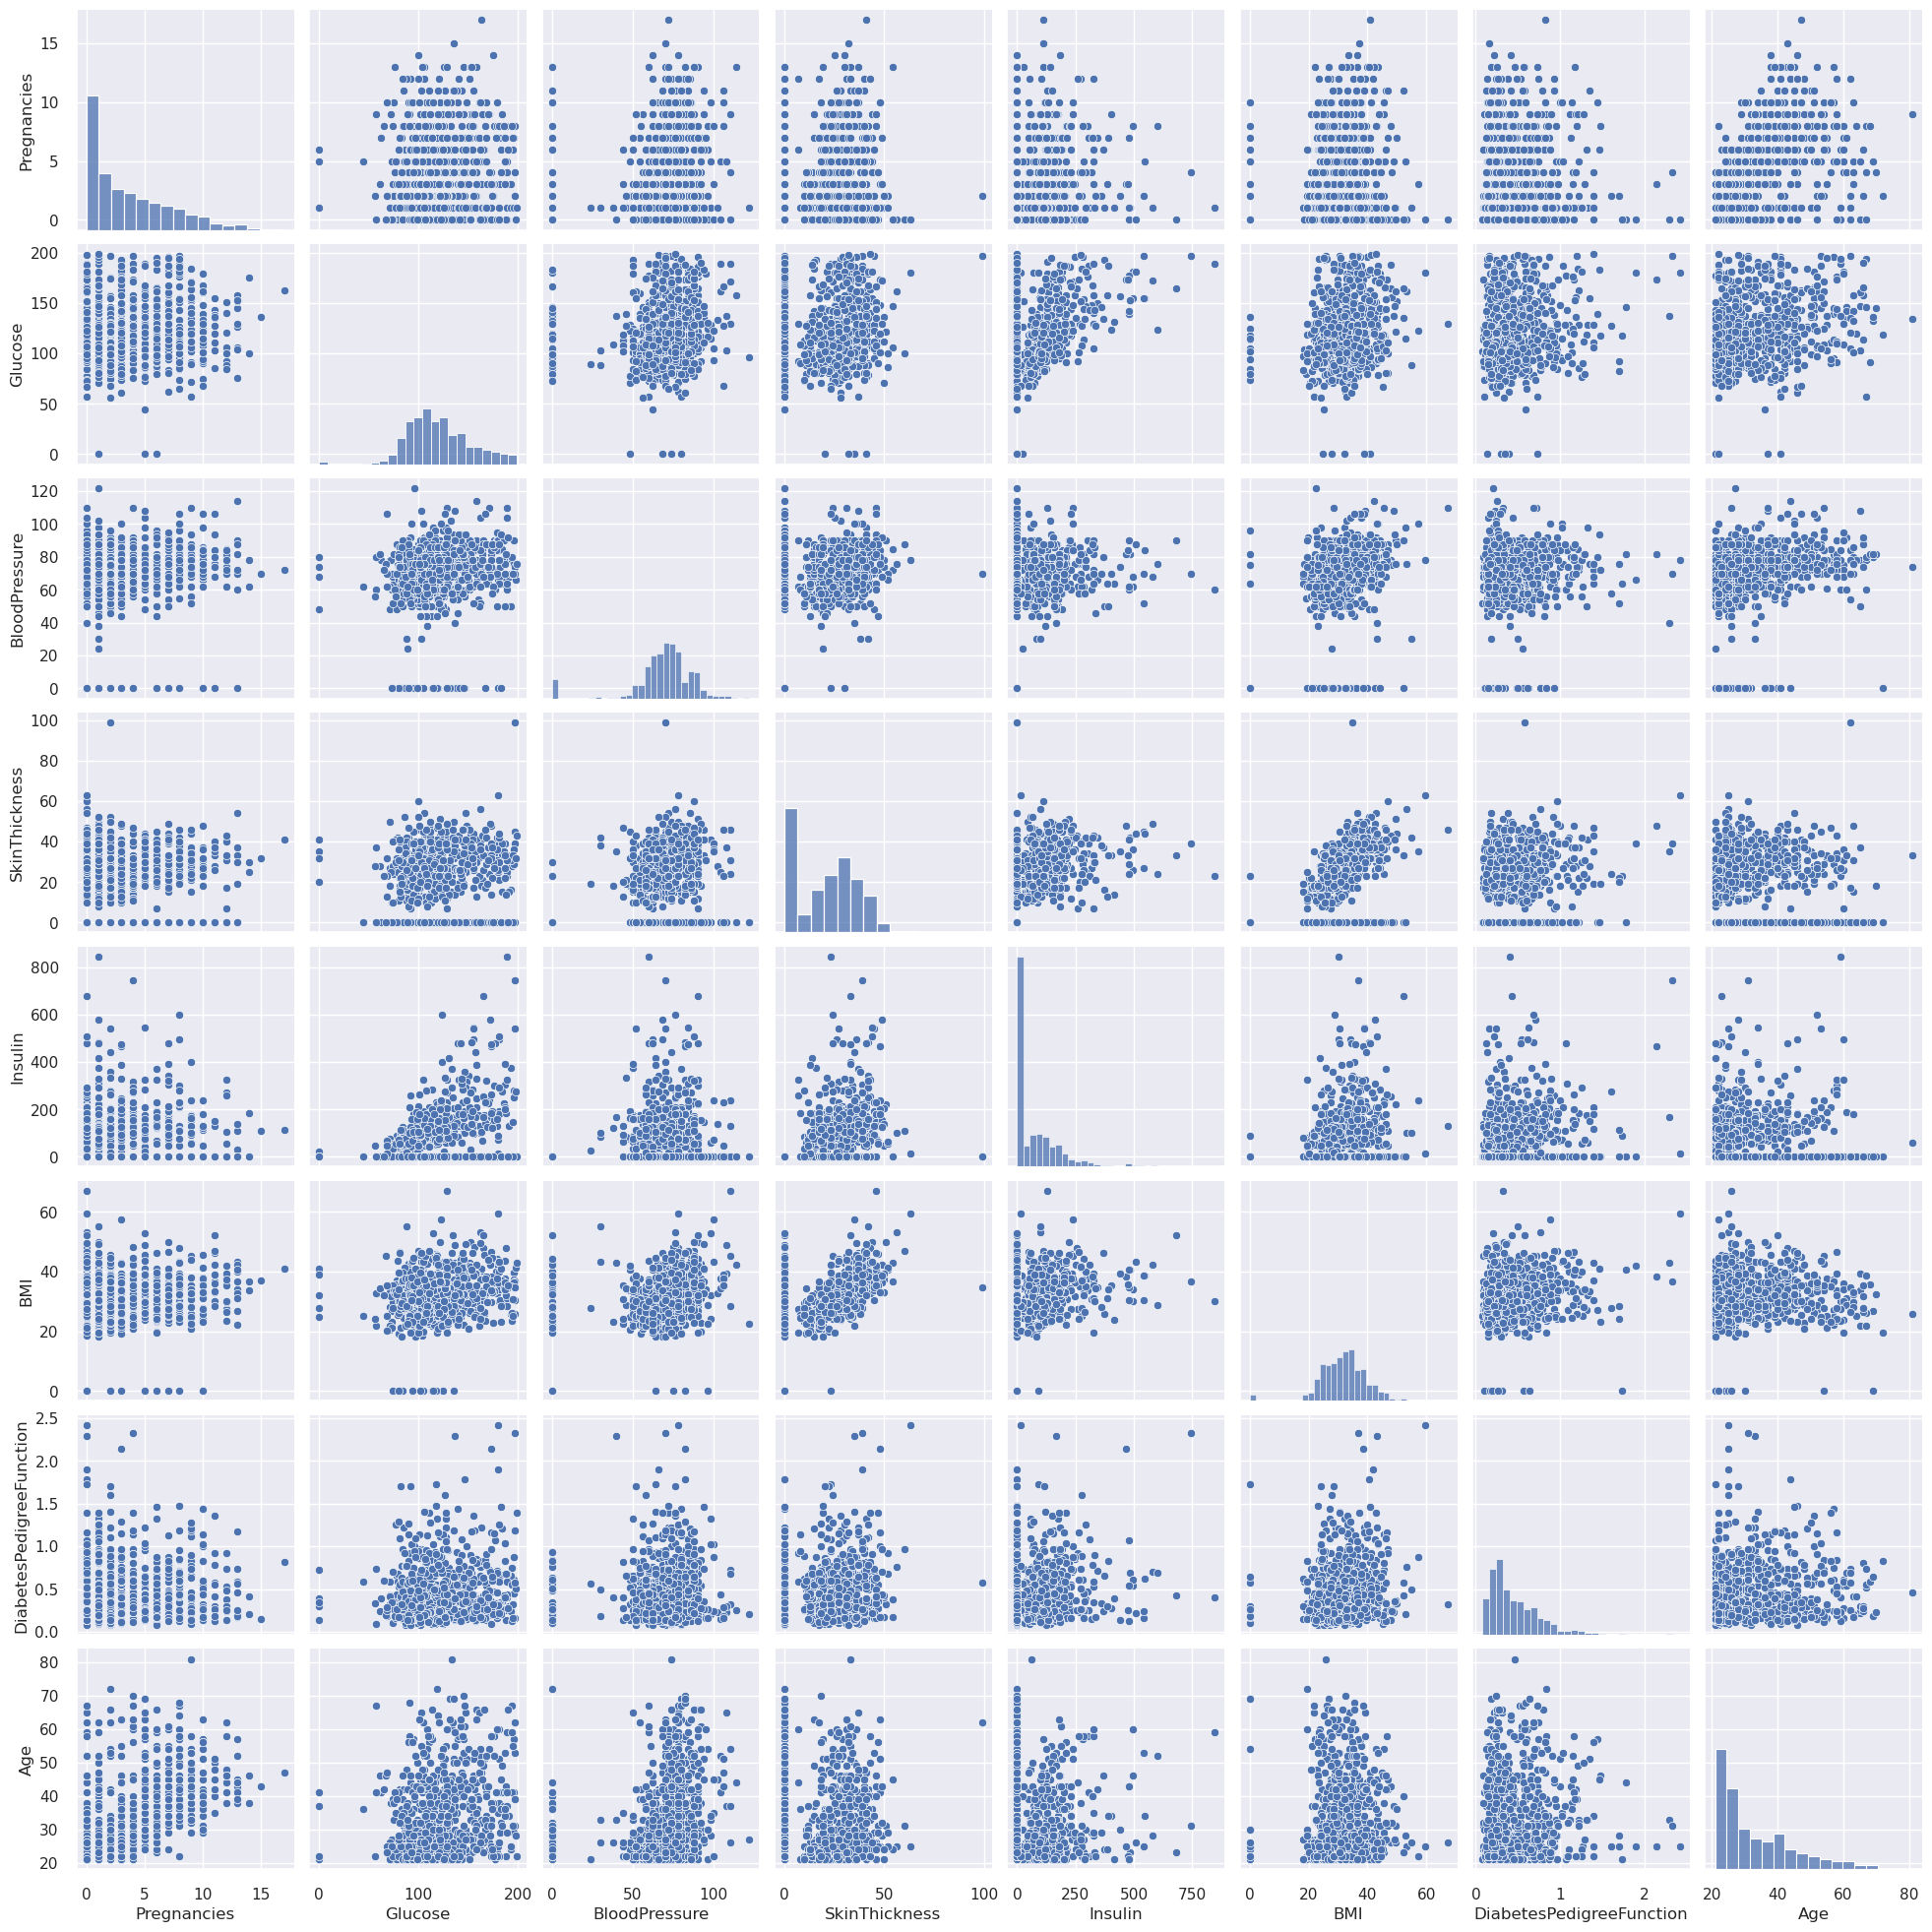

In [12]:
# Wpływ zer na kształt i rozkład danych w zbiorze:
sns.pairplot(df.loc[:, df.columns != 'Outcome'])

In [13]:
# Utowrzenie zbioru, w którym wartości '0' zostaną zastąpione przez NULL
df2 = df.copy()
for column in df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].columns:
    df2[column].replace([0], np.NAN, inplace=True)

In [14]:
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].isin([0]).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [15]:
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].isna().sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

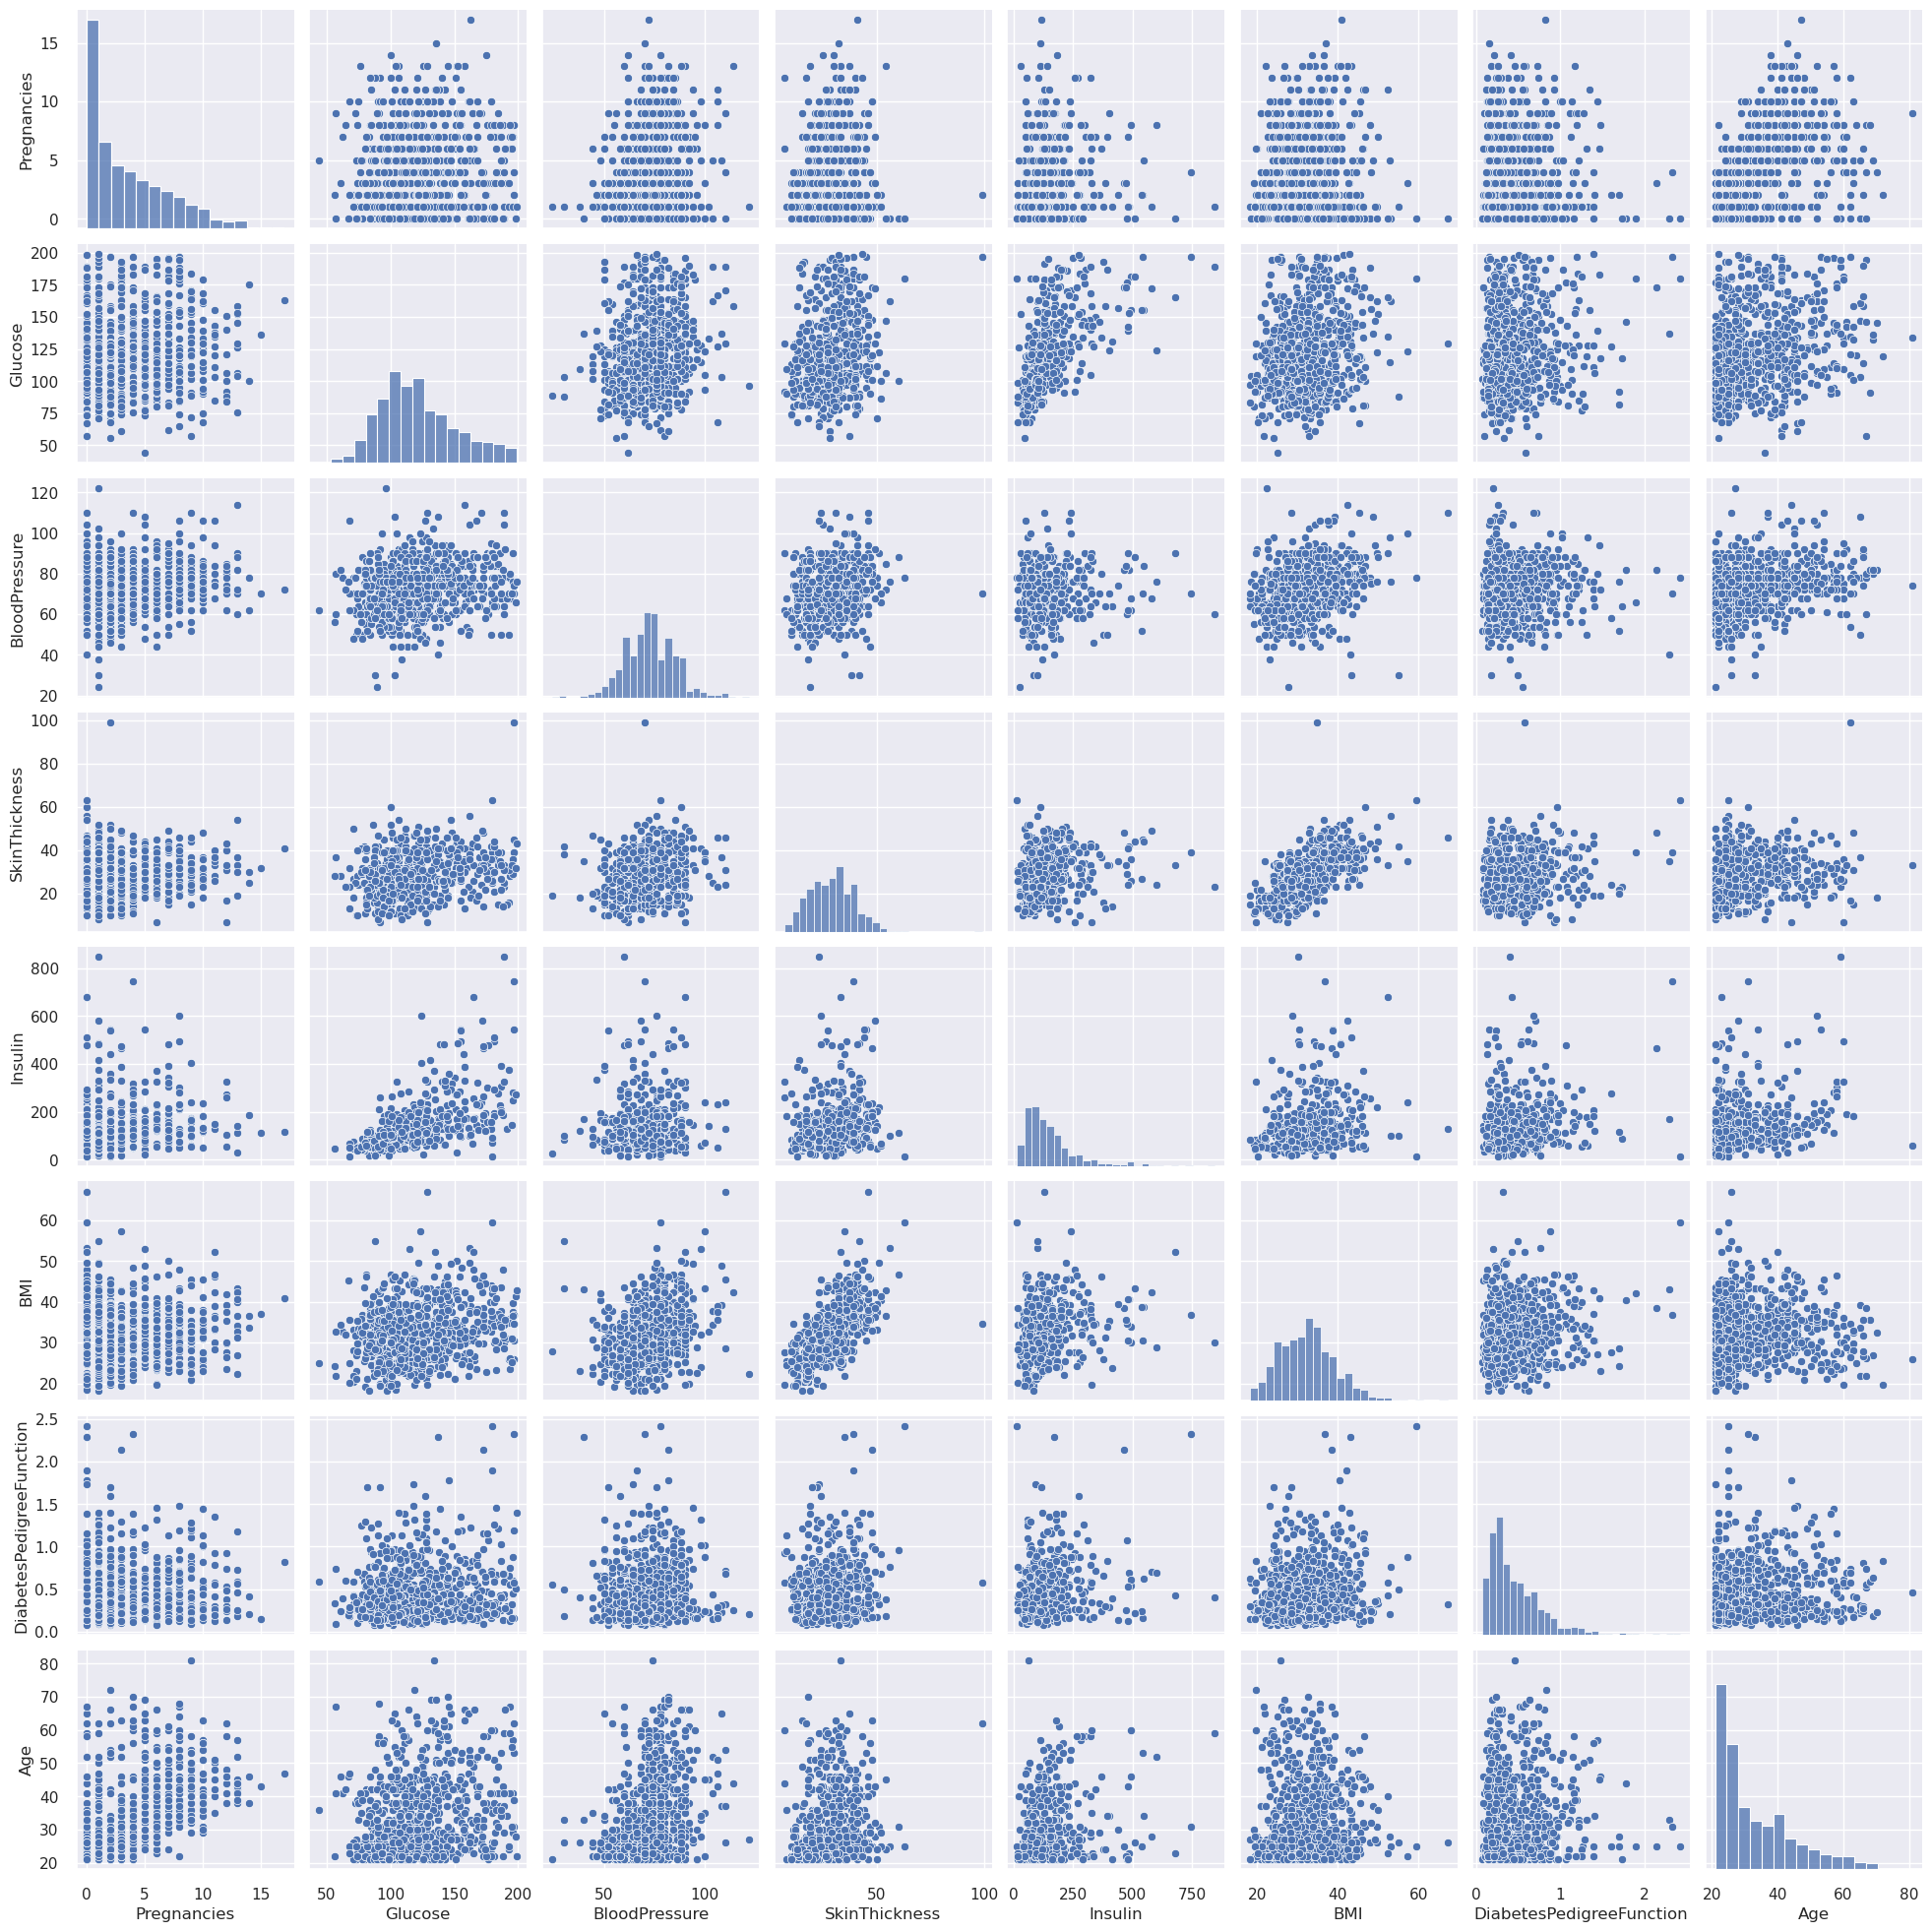

In [16]:
# Sprawdzenie jak zmienia się rozkład danych po zastąpieniu '0' na np.NAN:
sns.pairplot(df2.loc[:, df2.columns != 'Outcome'])

#### Sprawdzenie udziału poszczególnych kategorii


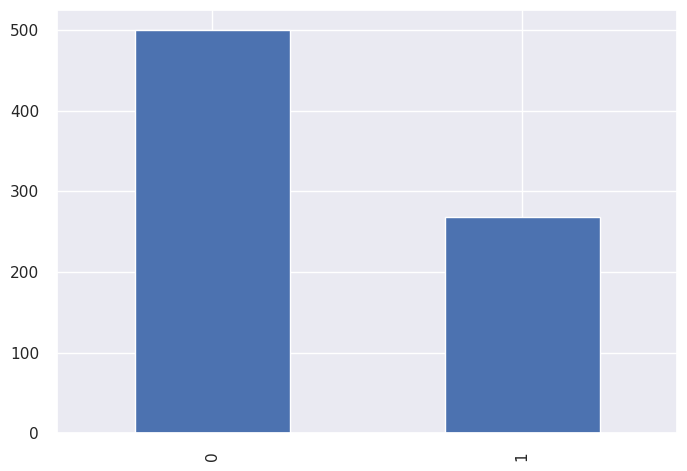

In [17]:
df['Outcome'].value_counts().plot(kind="bar")
plt.show()

Dane są dość słabo zabalansowane - rekordów dla kategorii '0' jest dwukrotnie więcej.

### Wykresy
1. Pudełko
2. Histogram

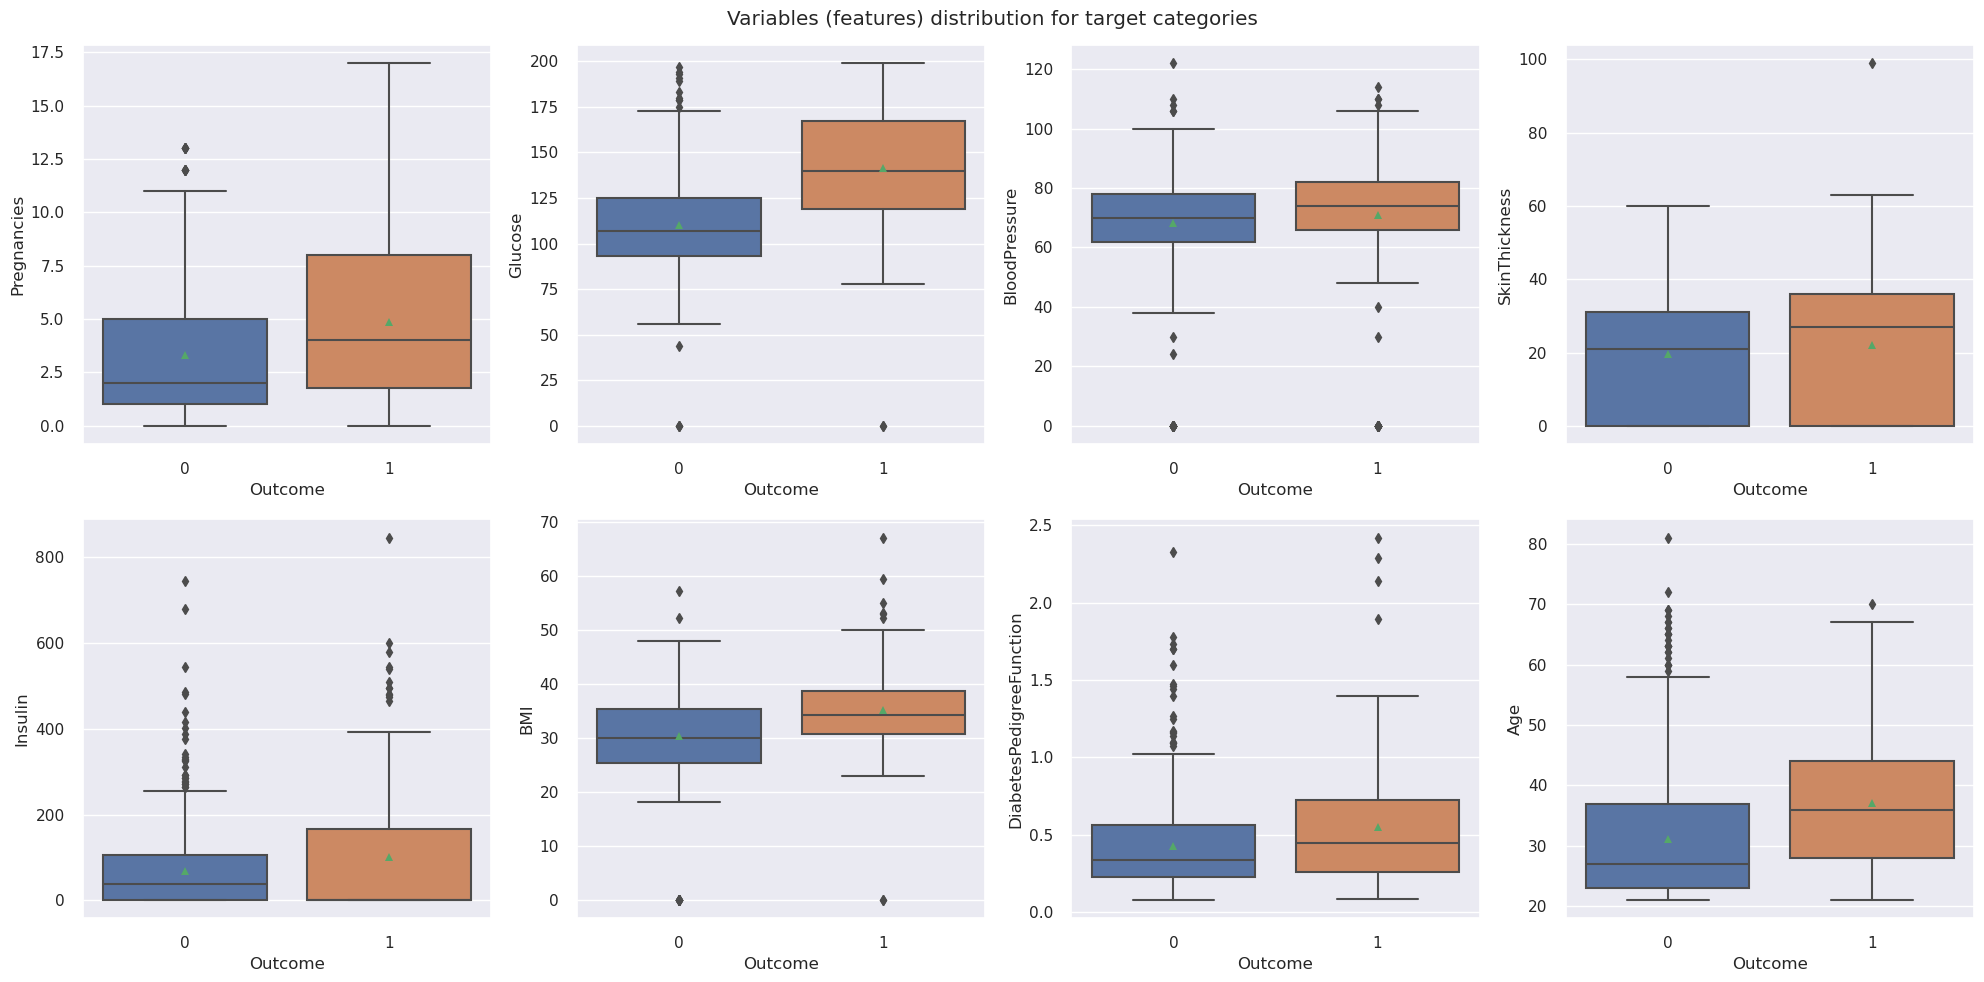

In [18]:
# Boxplots
features = list(df.loc[:, df.columns != 'Outcome'].columns)
target = 'Outcome'

def draw_boxplot(df, features, target):

    if len(features)%4 !=0:
        nrows = (len(df.columns)-1)//4+1
    else:
        nrows = (len(df.columns)-1)//4

    fig, axes = plt.subplots(nrows, 4,figsize=(20, 10))
    fig.suptitle(f'Variables (features) distribution for target categories')
    
    row=0
    i=0
    
    for feature in features:
            sns.boxplot(data=df, x=target, y=feature, showmeans=True, meanprops={"markeredgecolor": "yellow"},ax=axes[row,i])
            i += 1
            if i > 3:
                i = 0
                row += 1
    plt.tight_layout()
    plt.show()
    
draw_boxplot(df, features, target)

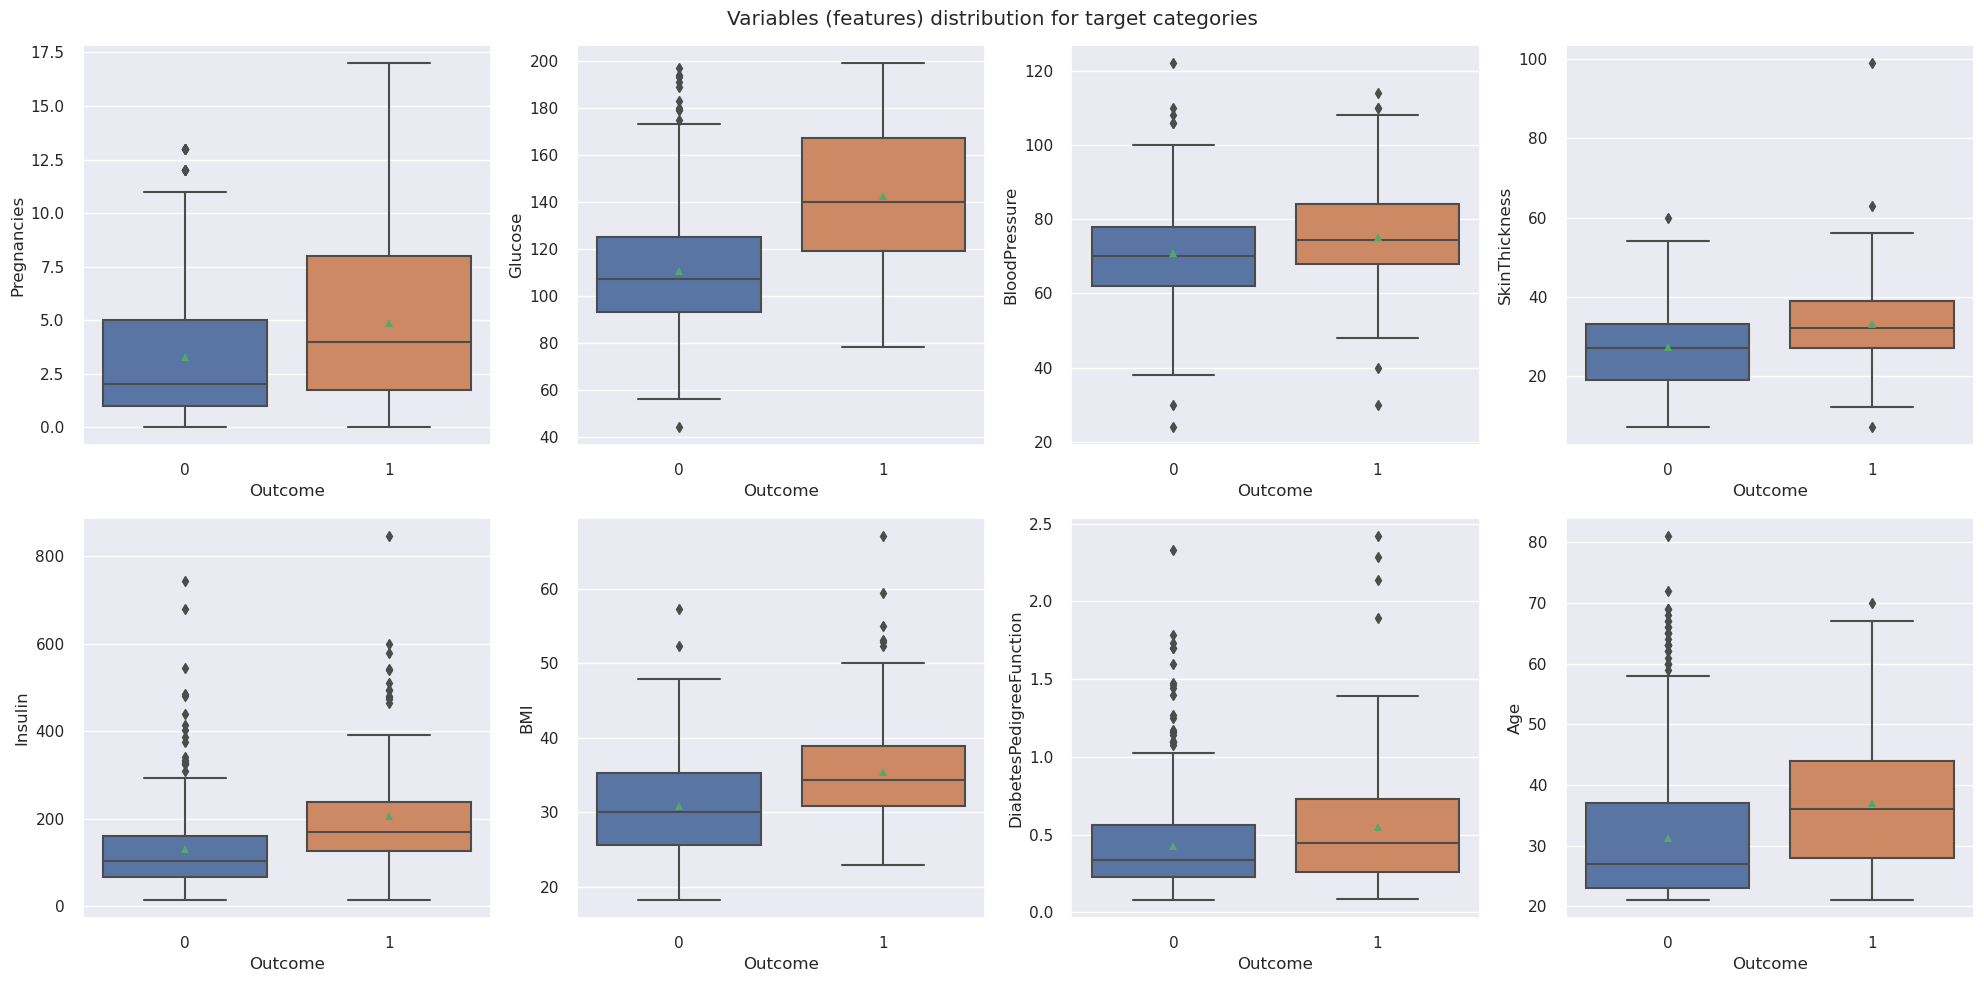

In [19]:
# Dla danych z NULL'ami (wartości pominięte przy tworzeniu wykresów)
draw_boxplot(df2, features, target)

* Dla wszystkich zmiennych widać różnicę mediany i średniej w zależności od kategorii. Wszystkie mogą mieć istotny wpływ na przewidywaną kategorię.
* Wartości odpowiednich zmiennych mają we wszystkich przypadkach wyższe wartości dla kategorii '1', cukrzyków. 
* Dla danych, w których pomięte zostały braki (df2) wyraźnie zmienia się rozkład danych i odpowiednie parametry (średnia/mediana)


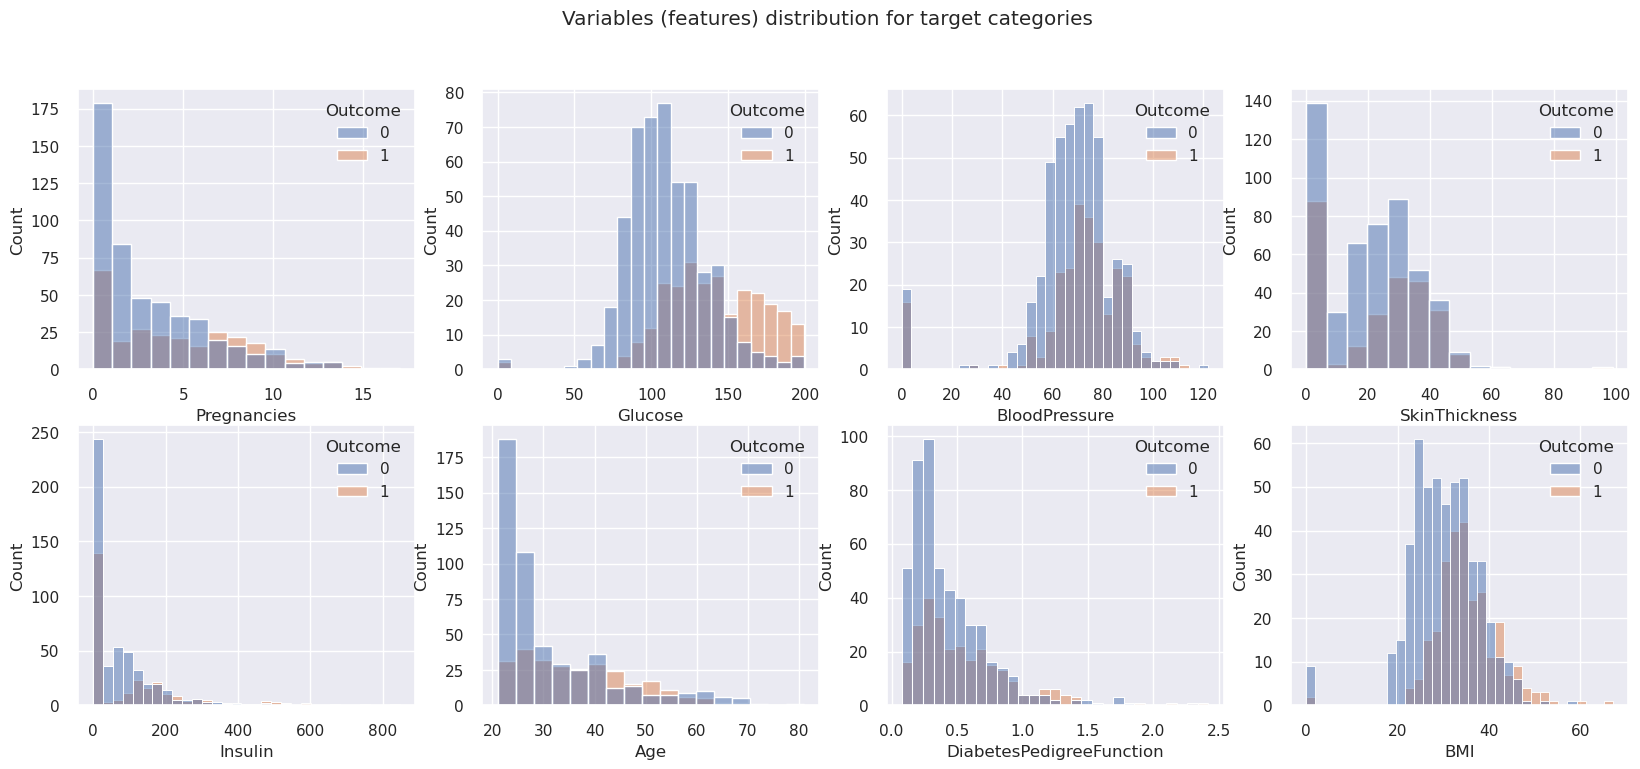

In [20]:
# Histograms
def draw_histogram(df, features, target):
    fig, axes = plt.subplots(2, 4,figsize=(20, 8))
    fig.suptitle(f'Variables (features) distribution for target categories')
    for i,feature in enumerate(features):
        if i < 4:
            sns.histplot(data=df, x=feature, hue=target,ax=axes[0,i])
        else:
            i=4-i
            sns.histplot(data=df, x=feature, hue=target,ax=axes[1,i])
    plt.show()

draw_histogram(df, features, target)

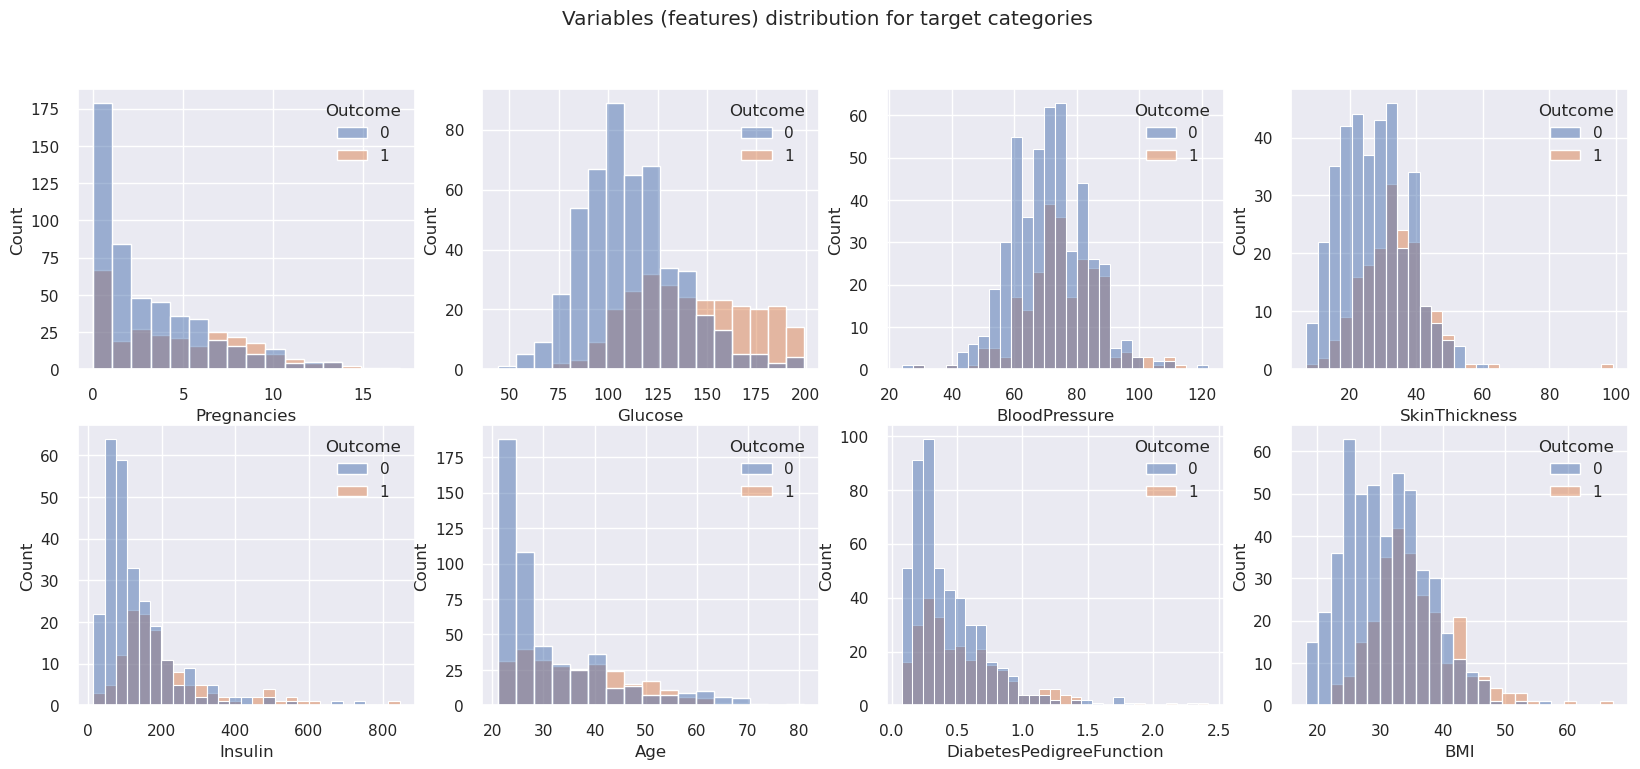

In [21]:
# Dla danych z NULL'ami
draw_histogram(df2, features, target)

* Analiza histogramów potwierdza wcześniejsze wnioski z analizy wykresów pudełkowych. Wartości '0' stanowią wyraźne wartości odbiegające. 

#### Sprawdzenie braków danych

In [22]:
# Braki w danych zostały już wstępnie przeanalizowane w poprzednich punktach.
# Dla zbioru, w którym wartości 0 zostały zastąpione przez np.NAN, ich procentowy udział wynosi odpowiednio:
for column in df2.columns:
    missing = df2[column].isna().sum() / df2.shape[0]
    print(f"{column:{25}}: ==============> {missing * 100:.2f}%")

Pregnancies              : ==============> 0.00%
Glucose                  : ==============> 0.65%
BloodPressure            : ==============> 4.56%
SkinThickness            : ==============> 29.56%
Insulin                  : ==============> 48.70%
BMI                      : ==============> 1.43%
DiabetesPedigreeFunction : ==============> 0.00%
Age                      : ==============> 0.00%
Outcome                  : ==============> 0.00%


In [23]:
# Metoda I - uzupełnienie braków:
# Z uwagi na skośny rozkład dla zmiennej 'Insulin' i 'SkinThickness'  braki uzupełniam medianą:

df3 = df.copy()
for column in df3[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].columns:
    df3[column].replace([0], np.NAN, inplace=True)
    if column in ['SkinThickness','Insulin']:
        df3[column].fillna(df3[column].median(), inplace=True)
    else:
        df3[column].fillna(df3[column].mean(), inplace=True)
    # mediana = df3.groupby('Outcome')[column].transform('median')
    # df3[column].fillna(mediana, inplace=True)
    

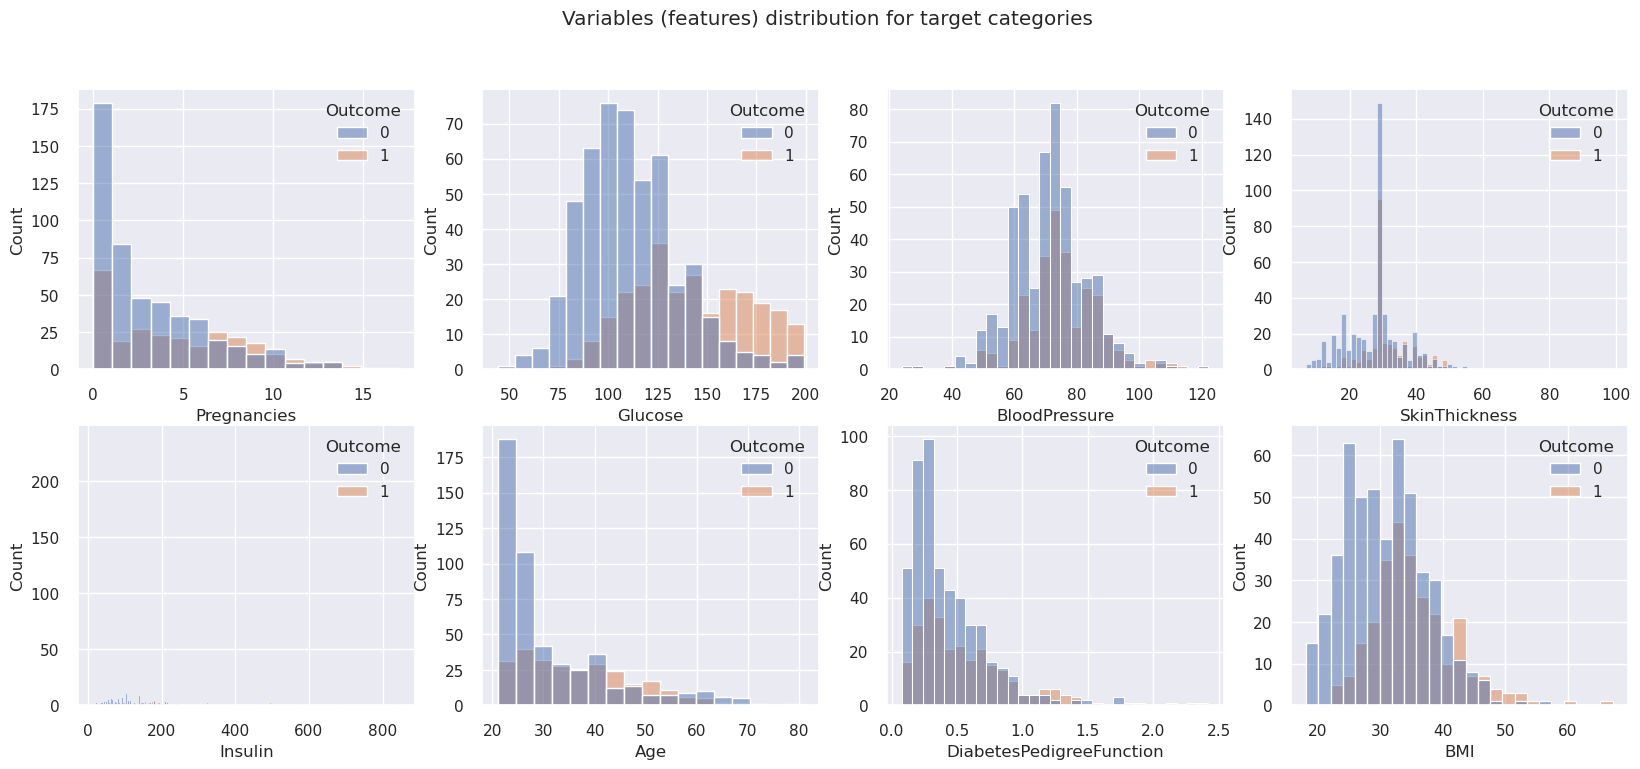

In [24]:
# Rozkład po transformacji
draw_histogram(df3,features,target)

In [25]:
# Metoda II - usunięcie braków dla 'Insulin' i 'SkinThickness' :
df2.dropna(subset=['SkinThickness','Insulin'], inplace=True)

for column in df2[['Glucose','BloodPressure','BMI']].columns:
        df2[column].fillna(df2[column].mean(), inplace=True)

for column in df2.columns:
    missing = df2[column].isna().sum() / df2.shape[0]
    print(f"{column:{25}}: ==============> {missing * 100:.2f}%")

Pregnancies              : ==============> 0.00%
Glucose                  : ==============> 0.00%
BloodPressure            : ==============> 0.00%
SkinThickness            : ==============> 0.00%
Insulin                  : ==============> 0.00%
BMI                      : ==============> 0.00%
DiabetesPedigreeFunction : ==============> 0.00%
Age                      : ==============> 0.00%
Outcome                  : ==============> 0.00%


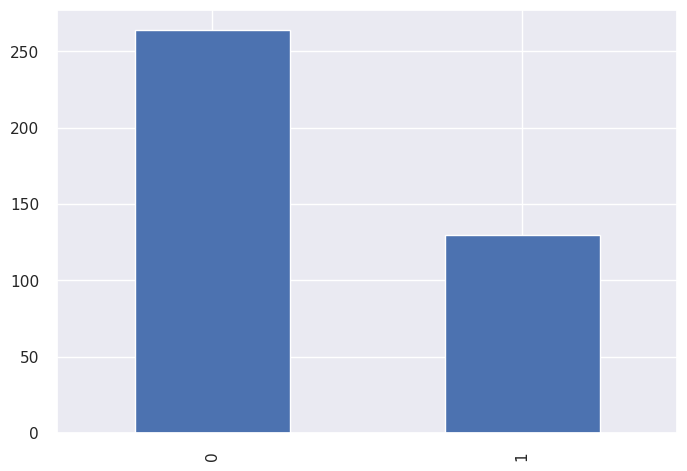

In [26]:
# Udział poszczególnych kategorii po usunięciu części danych
df2['Outcome'].value_counts().plot(kind="bar")
plt.show()

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               394 non-null    int64  
 1   Glucose                   394 non-null    float64
 2   BloodPressure             394 non-null    float64
 3   SkinThickness             394 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       394 non-null    float64
 6   DiabetesPedigreeFunction  394 non-null    float64
 7   Age                       394 non-null    int64  
 8   Outcome                   394 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 30.8 KB


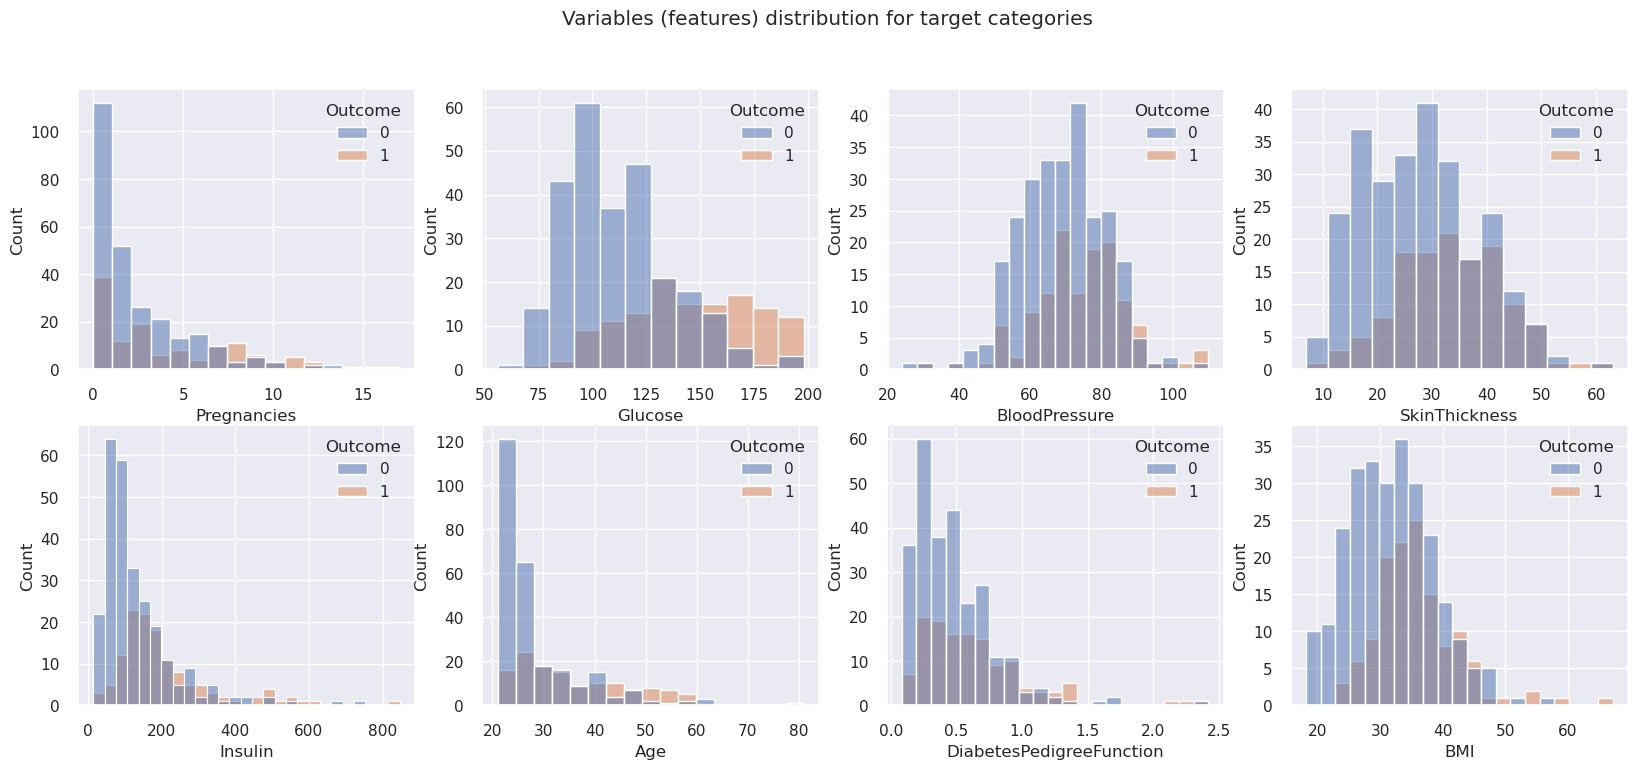

In [28]:
draw_histogram(df2,features,target)

In [29]:
# Metoda III - usunięcie kolumn Insulin i SkinThickness:
df4 = df3.drop(['Insulin','SkinThickness'], axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   BMI                       768 non-null    float64
 4   DiabetesPedigreeFunction  768 non-null    float64
 5   Age                       768 non-null    int64  
 6   Outcome                   768 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 42.1 KB


* W przypadku zastąpienia wartości NULL odpowiednimi medianami, rozkład zmiennych znacząco się zmienia - wyraźne silne sygnały dla odpowiednich wartości, może to mieć duży wpływ na dalszą analizę.
* w przypadku usunięcia wierszy zawierających puste komórki znacząco redukujemy ilość danych, jednak ich rozkład jest stosunkowo równomierny.
* Do dalszej analizy pozostawiam oba zbiory danych.

#### Korelacja

* df - wyjściowy zbiór danych zawierający wartości '0',<br>
* df2 - zbiór danych, w którym wartości '0' dla wybranych kolumn zostały zastąpione np.NAN, a następnie usunięte (znaczące zmniejszenie zbioru danych),
* df3 - wartości np.NAN zastąpione zostały medianą
* df4 - wartości np.NAN zastąpione zostały medianą, a dwie kolumny z dużą ilością braków - usunięte

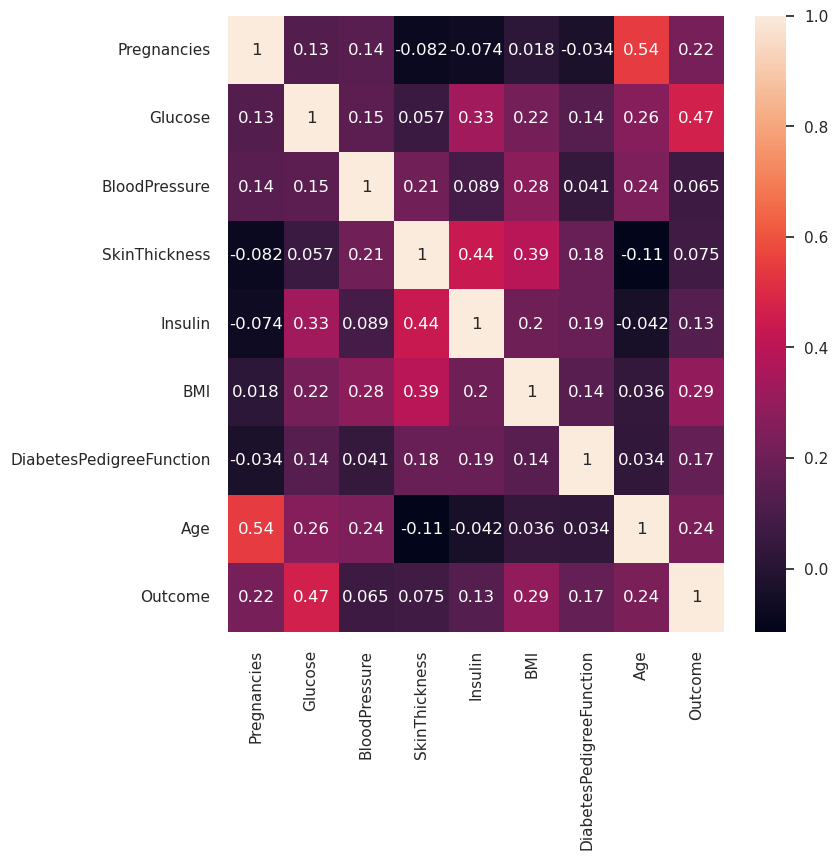

In [30]:
corr_matrix = df.corr()
plt.figure(figsize = (8,8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

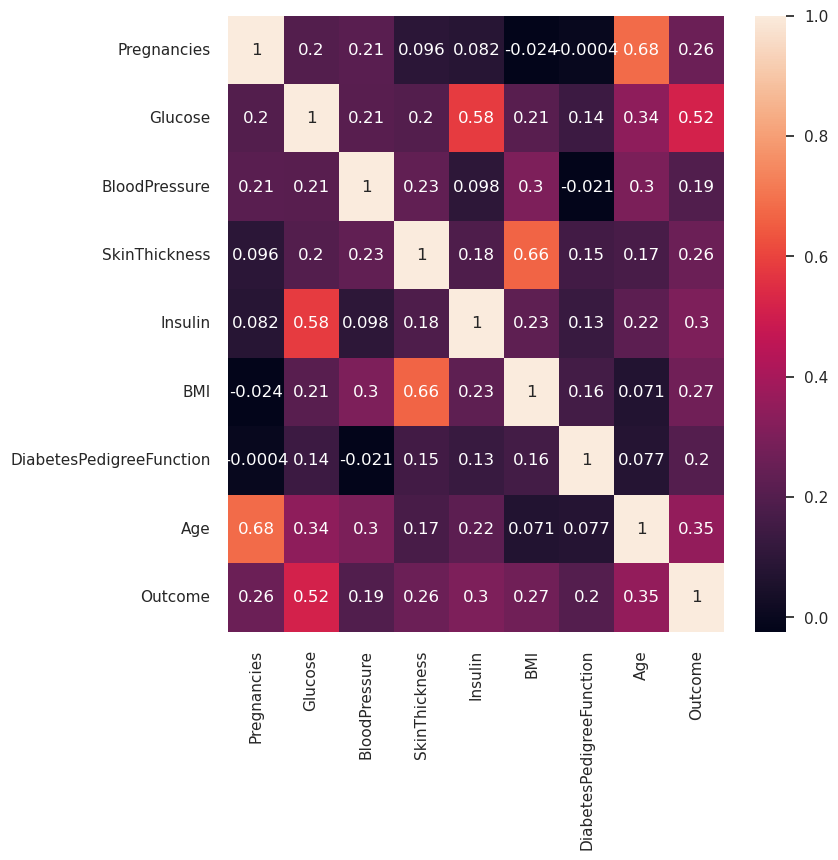

In [31]:
corr_matrix = df2.corr()
plt.figure(figsize = (8,8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

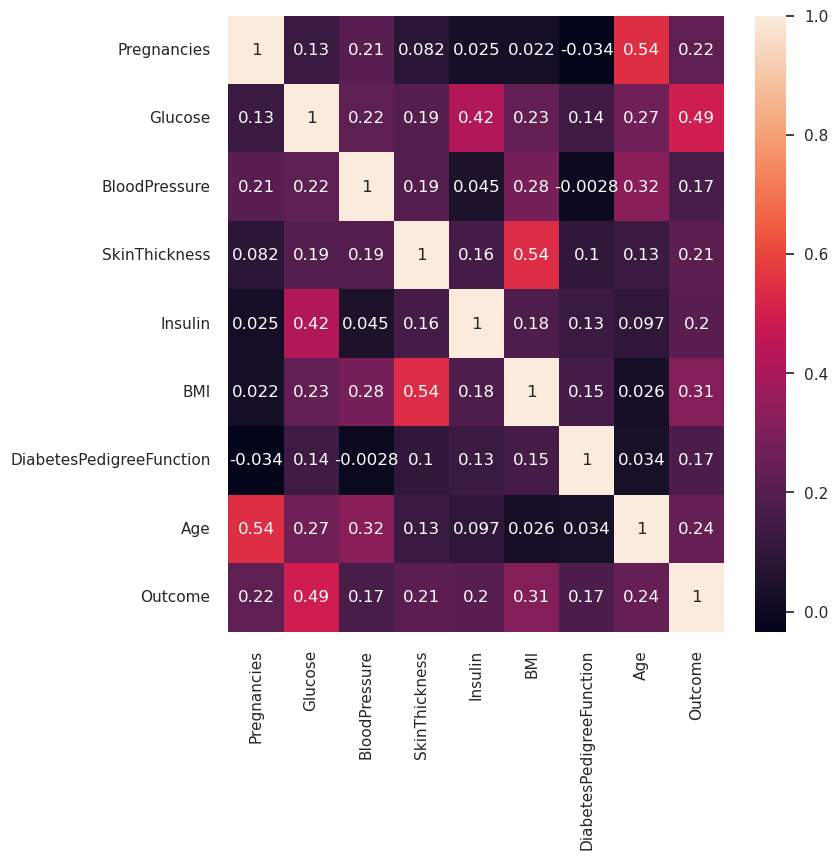

In [32]:
corr_matrix = df3.corr()
plt.figure(figsize = (8,8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

* Współczynniki korelacji najsilniej skorelowanych par zmiennych 'Age-Pregnancies', 'BMI-SkinThickness' < 0.7.
* Zarówno usunięcie wierszy pierwotnie zawierających wartości '0' dla wybranych kolumn jak i zastąpienie ich wartościami odpowiednich median zwiększa współczynnik korelacji pomiedzy zmiennymi oraz zmiennych i targetu. 

### Feature Engineering

#### Stworzenie zmiennych 0-1 dla kategorii


In [33]:
# w zbiorze nie ma danych kategorycznych 

#### Zbadanie zależności zmiennych 0-1 na target

In [34]:
# -----

#### Sprawdź inne dwie zmienne kateogoryczne w podobny sposób

In [35]:
# -----

#### Wytypowanie zmiennych na podstawie korelacji i analizy zmiennych 0-1

* Do dalszej analizy użyte zostaną wszystkie zmienne

In [134]:
X = df2.loc[:, df2.columns != 'Outcome'].values
y = df2['Outcome'].values

# X = df3.loc[:, df3.columns != 'Outcome'].values
# y = df3['Outcome'].values 

# X = df.loc[:, df.columns != 'Outcome'].values
# y = df['Outcome'].values 

# X = df4.loc[:, df4.columns != 'Outcome'].values
# y = df4['Outcome'].values 

In [122]:
print(f"""X shape: {X.shape}
y shape: {y.shape}""")

X shape: (394, 8)
y shape: (394,)


### Przygotowanie zbioru
#### Podział zbioru na treningowy i testowy

In [138]:
# z uwagi na nierównomierny podział pomiędzy kategorie, stosuje funkcje 'stratify' przy podziale danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [137]:
X

array([[  1.   ,  89.   ,  66.   , ...,  28.1  ,   0.167,  21.   ],
       [  0.   , 137.   ,  40.   , ...,  43.1  ,   2.288,  33.   ],
       [  3.   ,  78.   ,  50.   , ...,  31.   ,   0.248,  26.   ],
       ...,
       [  2.   ,  88.   ,  58.   , ...,  28.4  ,   0.766,  22.   ],
       [ 10.   , 101.   ,  76.   , ...,  32.9  ,   0.171,  63.   ],
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ]])

In [136]:
X_train

array([[  2.   , 112.   ,  68.   , ...,  34.1  ,   0.315,  26.   ],
       [  0.   , 138.   ,  60.   , ...,  34.6  ,   0.534,  21.   ],
       [  4.   , 146.   ,  85.   , ...,  28.9  ,   0.189,  27.   ],
       ...,
       [  1.   , 140.   ,  74.   , ...,  24.1  ,   0.828,  23.   ],
       [  3.   , 111.   ,  58.   , ...,  29.5  ,   0.43 ,  22.   ],
       [  1.   ,  84.   ,  64.   , ...,  36.9  ,   0.471,  28.   ]])

#### Standaryzacja

In [220]:
# StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler,QuantileTransformer,PowerTransformer,Normalizer
model = PowerTransformer()
X_train_scaled = model.fit_transform(X_train)
X_test_scaled = model.transform(X_test)

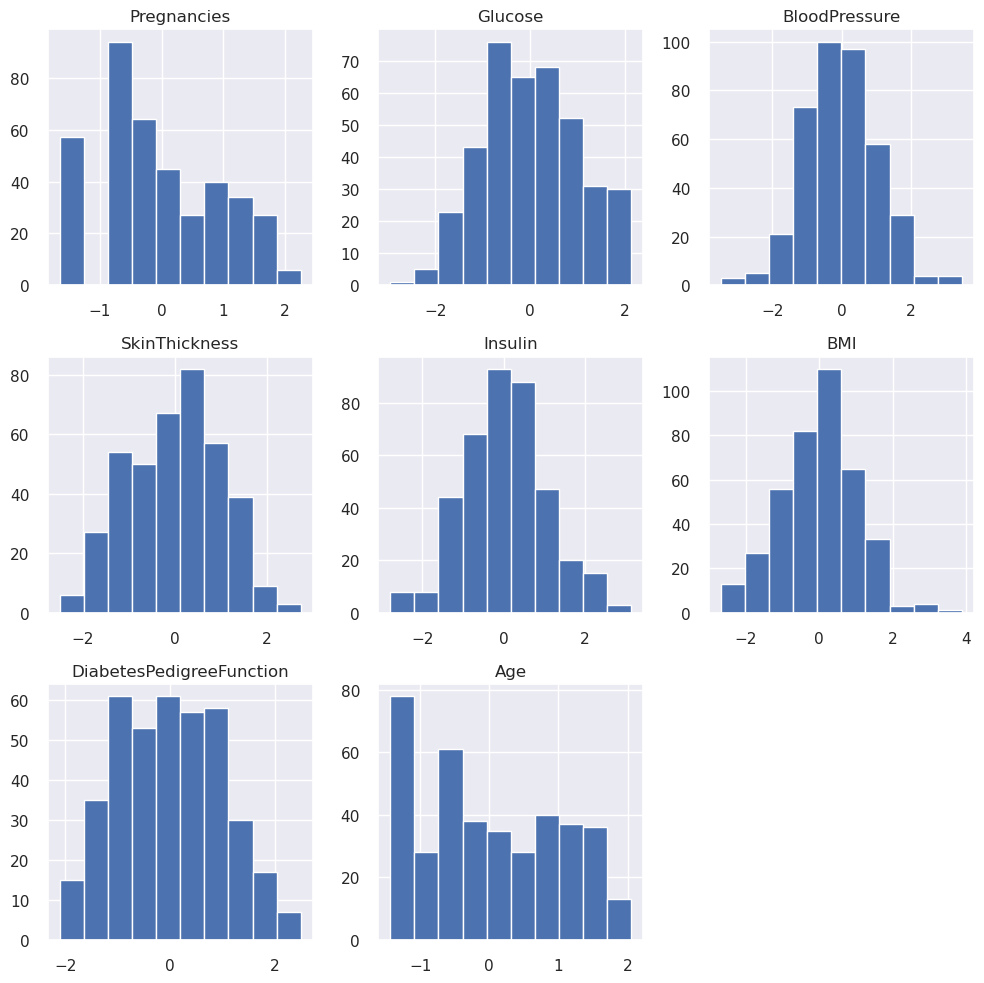

In [221]:
# Rozkład danych po skalowaniu
df_X_train_scaled = pd.DataFrame(X_train_scaled)
df_X_test_scaled = pd.DataFrame(X_test_scaled)
df_scaled = pd.concat([df_X_train_scaled,df_X_test_scaled],axis=0)
df_scaled.columns = list(df2.columns)[:8]
df_scaled.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

#### Analiza głównych składowych

In [222]:
pca = PCA(n_components=5) # liczba komponentów [1-8] 
# pca = PCA(n_components=0.75) # lub % zmienności [0-1]
X_train_scaled_PCA = pca.fit_transform(X_train_scaled)
X_test_scaled_PCA = pca.transform(X_test_scaled)

# sprawdzenie jaki % zmienności wyjaśniają kolejne główne składowe
print(pca.explained_variance_ratio_)

# % zmienności wyjaśniony przez zadaną liczbę zmiennych
print(pca.explained_variance_ratio_.sum())

# ilośc głownych składowych wyjąsniająca zadany % zmienności
n_pcs = pca.components_.shape[0]

print(n_pcs)

[0.33584438 0.18446126 0.14147294 0.12712052 0.08851127]
0.8774103692089084
5


### Estymacja modelu klasyfikacyjnego

Użyj wybranego modelu klasyfikacyjnego znanego Ci z zajęć. Wyestymuj dwa modele - jeden na wystandaryzowanych danych, a drugi na PCA.  

In [223]:
# Model podstawowy

classifier = LogisticRegression(random_state=42,class_weight='balanced',max_iter=1000)
classifier.fit(X_train_scaled, y_train)            
print(f1_score(y_train, classifier.predict(X_train_scaled), average='weighted'))

classifier_PCA = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
classifier_PCA.fit(X_train_scaled_PCA, y_train)
print(f1_score(y_train, classifier_PCA.predict(X_train_scaled_PCA), average='weighted'))            


# classifier = RandomForestClassifier(max_depth=5, n_estimators=50, bootstrap=True, random_state=42,class_weight='balanced')
# classifier.fit(X_train_scaled, y_train)            
# y_pred = classifier.predict(X_test_scaled)        
# y_fit_train = classifier.predict(X_train_scaled)  

# classifier_PCA = RandomForestClassifier(max_depth=5, n_estimators=50, bootstrap=True, random_state=42, class_weight='balanced')
# classifier_PCA.fit(X_train_scaled_PCA, y_train)            
# y_pred_PCA = classifier_PCA.predict(X_test_scaled_PCA)        
# y_fit_train_PCA = classifier_PCA.predict(X_train_scaled_PCA)   


0.7798480670659502
0.7684424419118296


In [ ]:
# Cross-validation LeaveOneOut()

cv_lv = LeaveOneOut()
classifier_lv = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
sc_lv = cross_val_score(classifier_lv, X_train_scaled, y_train, cv=cv_lv, scoring='f1_weighted')
classifier_lv.fit(X_train_scaled, y_train)
print(np.mean(sc_lv))

cv_PCA_lv = LeaveOneOut()
classifier_PCA_lv = LogisticRegression(random_state=42, class_weight='balanced',max_iter=1000)
sc_PCA_lv = cross_val_score(classifier_PCA_lv, X_train_scaled_PCA, y_train, cv=cv_PCA_lv, scoring='f1_weighted')
classifier_PCA_lv.fit(X_train_scaled_PCA, y_train)
print(np.mean(sc_PCA_lv))

In [182]:
def train_model(X_train,y_train,folds,model):
    scores=[]
    for train_index, valid_index in folds.split(X_train, y_train):
        X_train_n,X_valid_n = X_train[train_index],X_train[valid_index]
        y_train_n,y_valid_n = y_train[train_index],y_train[valid_index]
        scaler = PowerTransformer()
        X_train_n = scaler.fit_transform(X_train_n)
        X_vaid_n = scaler.transform(X_valid_n)
        model.fit(X_train_n,y_train_n)
        y_pred_valid_n = model.predict(X_valid_n)

        scores.append(recall_score(y_valid_n, y_pred_valid_n))

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

folds = StratifiedKFold(10,shuffle=True,random_state=0)
lr = LogisticRegression(class_weight='balanced',penalty='l2', C=1e-05, solver='lbfgs')

In [183]:
train_model(X_train,y_train, folds,lr)

CV mean score: 1.0000, std: 0.0000.


In [199]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline


def get_params_SVC():    
        tuned_parameters = {
        'C':            ([0.1, 0.01, 0.001, 1, 10, 100]),              
        'kernel':       ['linear', 'rbf','poly'],                
        'degree':       ([1,2,3,4,5]),
        'gamma':         [1, 0.1, 0.01, 0.001, 0.0001],
        }
        return(tuned_parameters)

#__scv necessary for pipeline function
def get_params_SVC_pipeline():    
        tuned_parameters = {
        'svc__C':            ([0.1, 0.01, 0.001, 1, 10, 100]),             
        'svc__kernel':       ['linear', 'rbf','poly'],                
        'svc__degree':       ([1,2,3,4,5]),
        'svc__gamma':         [1, 0.1, 0.01, 0.001, 0.0001],
        }
        return(tuned_parameters)

def get_params_lr():    

    tuned_parameters = {
    'solver':      ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty':     ['none','l1', 'l2', 'elasticnet'],
    'C':           [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]        

        }
    return(tuned_parameters)

def get_params_xgboost():
        tuned_parameters = {
        'solver':      ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty':     ['none','l1', 'l2', 'elasticnet'],
        'C':           [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]        

        }
        return(tuned_parameters)        


In [ ]:
folds = StratifiedKFold(10,shuffle=True,random_state=0)
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=4000)
# svc = svm.SVC(class_weight ='balanced',probability = True)
# define search
search = GridSearchCV(model, get_params_lr(), scoring='f1', n_jobs=-1, verbose=1,cv=folds)
# execute search
result = search.fit(X_train_scaled, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [201]:
result.best_score_

0.95

In [206]:
svc_opt = svm.SVC(C=0.01, degree=3, gamma=0.1, kernel='poly',class_weight ='balanced',probability = True)
svc_opt.fit(X_train_scaled,y_train)

SVC(C=0.01, class_weight='balanced', gamma=0.1, kernel='poly', probability=True)

In [216]:
result.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [225]:
lr = LogisticRegression(class_weight='balanced',penalty='l1', C=0.1, solver='liblinear')
lr.fit(X_train_scaled_PCA,y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [228]:
! pip install xgboost  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.3 MB/s eta 0:00:0000:0100:01


In [229]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [230]:
scaling_models = {
'standard_scaler' : StandardScaler(),
'min_max_scaler' : MinMaxScaler(),
'max_abs_scaler' : MaxAbsScaler(),
'robust_scaler' : RobustScaler(),
'quantile_transformer_normal' : QuantileTransformer(output_distribution='normal'),
'quantile_transformer_uniform' : QuantileTransformer(output_distribution='uniform'),
'power_transformer_YeoJohnson' : PowerTransformer(method='yeo-johnson'),
'normalizer' : Normalizer()}

In [245]:
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
def find_best_params(models;list, X, y, cv):

    # Initiate a DataFrame for the averages and a list for all measures

    cv_metrics = pd.DataFrame()
    list_params_pipe = []  
    list_scores_pipe = []   
    test_scores_pipe = []

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            
            pipe = Pipeline([('scaler', scaler), ('model', model)])
            parameters = params[model]
            search = GridSearchCV(pipe, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1,verbose = 1,cv = cv)
            # execute search
            result = search.fit(X_train_scaled, y_train)
            # summarize result
            print('Best Score: %s' % result.best_score_)
            print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:

    list_params_pipe.append(clf.best_params_)
    list_scores_pipe.append(clf.best_score_)

    preds = clf.predict_proba(X_test_n)
    test_scores_pipe.append(roc_auc_score(y_test_n,preds[:,1]))

     


print("Average test AUC (split)  : %.2f std: (%.2f)"%(np.mean(test_scores_split),np.std(test_scores_split)))
print("Average test AUC (Pipeline) : %.2f std: (%.2f)"%(np.mean(test_scores_pipe),np.std(test_scores_split)))

In [280]:
folds = StratifiedKFold(10,shuffle=True,random_state=0)

models={
    
    'LogistricRegression': LogisticRegression(random_state=42, class_weight='balanced',max_iter=10000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'SVMClassifier': OneVsRestClassifier(SVC(class_weight='balanced')),
    'XGBoostClassifier': XGBClassifier(class_weight='balanced',random_state=42)
    # 'XGBoostClassifier': XGBClassifier(class_weight='balanced',objective='multi:softmax', random_state=42, n_class=3)
    }


def cv_comparison(models, scalers, X, y, cv):

    # Initiate a DataFrame for the averages and a list for all measures

    cv_metrics = pd.DataFrame()
    accuracy_scores = []
    f1_scores = []
    recall_scores = []
    precision_scores = []
    roc_auc_scores = []

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of 
    # all CVs to the list
    for model_name, model in models.items():
        for scaler_name, scaler in scalers.items():
            
            pipe = Pipeline([('scaler', scaler), ('model', model)])

            accuracy = np.round(cross_val_score(pipe, X, y, scoring='accuracy', cv=cv), 4)
            accuracy_scores.append(accuracy)
            accuracy_avg = round(accuracy.mean(),4)
           

            f1 = np.round(cross_val_score(pipe, X, y, scoring='f1_macro', cv=cv), 4)
            f1_scores.append(f1)
            f1_avg = round(f1.mean(),4)
            

            precision = np.round(cross_val_score(pipe, X, y, scoring='precision_macro', cv=cv), 4)
            precision_scores.append(precision)
            precision_avg = round(precision.mean(),4)

            recall = np.round(cross_val_score(pipe, X, y, scoring='recall_macro', cv=cv), 4)
            recall_scores.append(recall)
            recall_avg = round(recall.mean(),4)

            roc_auc = np.round(cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv), 4)
            roc_auc_scores.append(roc_auc)
            roc_auc_avg = round(roc_auc.mean(),4)
            
            cv_metrics[str(model_name + '_' +scaler_name)] = [accuracy_avg, f1_avg, precision_avg, recall_avg,roc_auc_avg]
            
    cv_metrics.index = ['Accuracy', 'F1 score (macro)', 'Precision(macro)', 'Recall(macro)', 'ROC-AUC']
    return cv_metrics, accuracy_scores, f1_scores, recall_scores, precision_scores, roc_auc_scores

In [281]:
cv_metrics, accuracy_scores, f1_scores, recall_scores, precision_scores, roc_auc_scores = cv_comparison(models, scaling_models, X_train, y_train, folds)

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:15:48]

In [282]:
cv_metrics.T['Precision(macro)'].max()
# cv_metrics.T['Recall(macro)'].max()

0.7433

In [283]:
cv_metrics.T

,Accuracy,F1 score (macro),Precision(macro),Recall(macro),ROC-AUC
LogistricRegression_standard_scaler,0.7551,0.7344,0.7370,0.7460,0.8307
LogistricRegression_min_max_scaler,0.7650,0.7434,0.7429,0.7541,0.8349
LogistricRegression_max_abs_scaler,0.7619,0.7395,0.7411,0.7495,0.8399
LogistricRegression_robust_scaler,0.7520,0.7316,0.7343,0.7436,0.8320
LogistricRegression_quantile_transformer_normal,0.7485,0.7332,0.7338,0.7530,0.8321
LogistricRegression_quantile_transformer_uniform,0.7516,0.7381,0.7433,0.7632,0.8451
LogistricRegression_power_transformer_YeoJohnson,0.7516,0.7364,0.7396,0.7563,0.8489
LogistricRegression_normalizer,0.6470,0.6344,0.6540,0.6662,0.6889
RandomForestClassifier_standard_scaler,0.7528,0.7006,0.7218,0.6955,0.8341
RandomForestClassifier_min_max_scaler,0.7592,0.7079,0.7291,0.7029,0.8354


In [148]:
# Cross-validation kFold
cv_kfold = StratifiedKFold(n_splits=5)
classifier_kfold = LogisticRegression(random_state=42, class_weight='balanced',max_iter=10000)
# sc_kfold = cross_val_score(classifier_kfold, X_train_scaled, y_train, cv=cv_kfold, scoring='f1_weighted')
# classifier_kfold.fit(X_train_scaled, y_train)
# print(np.mean(sc_kfold))

# svc = svm.SVC(class_weight ='balanced',probability = True)
classifier_PCA_kfold = LogisticRegression(random_state=42, class_weight='balanced',max_iter=10000)
# sc_PCA_kfold = cross_val_score(classifier_PCA_kfold, X_train_scaled_PCA, y_train, cv=cv_PCA_kfold, scoring='f1_weighted')
# classifier_PCA_kfold.fit(X_train_scaled_PCA, y_train)
# print(np.mean(sc_PCA_kfold))

In [179]:
list_params_split = []  
list_scores_split = []   
test_scores_split = []

list_params_pipe = []  
list_scores_pipe = []   
test_scores_pipe = []

for i, (train_index, test_index) in enumerate(folds.split(X_train, y_train)):
    print("Iteration: ",i)
    X_train_n, X_test_n = X_train[train_index], X_test[test_index]
    y_train_n, y_test_n = y_train[train_index], y_test[test_index]

    scaler = StandardScaler()
    scaler = scaler.fit(X_train_n)
    X_train_n = scaler.transform(X_train_n)
    X_test_n = scaler.transform(X_test_n)

    parameters = get_params_SVC()
    svc = svm.SVC(class_weight ='balanced',probability = True)
    clf = GridSearchCV(svc, parameters,scoring = 'roc_auc', n_jobs = -1,
                       verbose = 1,cv = cv)
    clf.fit(X_train_n, y_train_n) 

    list_params_split.append(clf.best_params_)
    list_scores_split.append(clf.best_score_)

    preds = clf.predict_proba(X_test_n)
    test_scores_split.append(roc_auc_score(y_test_n,preds[:,1]))

    pipe = Pipeline([('scaler', StandardScaler()), ('svc', svm.SVC(
        class_weight ='balanced',probability = True))])
    
    parameters = get_params_SVC_pipeline()

    clf = GridSearchCV(pipe, param_grid = parameters,scoring = 'roc_auc',
                       n_jobs = -1,verbose = 1,cv = cv)
    clf.fit(X_train, y_train)

    list_params_pipe.append(clf.best_params_)
    list_scores_pipe.append(clf.best_score_)

    preds = clf.predict_proba(X_test_n)
    test_scores_pipe.append(roc_auc_score(y_test_n,preds[:,1]))

     


print("Average test AUC (split)  : %.2f std: (%.2f)"%(np.mean(test_scores_split),np.std(test_scores_split)))
print("Average test AUC (Pipeline) : %.2f std: (%.2f)"%(np.mean(test_scores_pipe),np.std(test_scores_split)))
     


Iteration:  0


IndexError: index 90 is out of bounds for axis 0 with size 79

* Zastosowanie kroswalidacji nie wpływa znacząco na poprawę modelu

### Ocena jakości modelu klasyfikacyjnego

Wyznacz accuracy, precision, lub inne miary znane Ci z zajęć, które uznasz za stosowne. Porównaj wyniki dla obydwu modeli na odpowiednich zbiorach (Dane wystandaryzowane, dane PCA)

In [165]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    report_train = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{report_train}")
    print("------------------------------------------------------------------------")

    print("TESTING RESULTS: \n===============================")
    report_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{report_test}")


    plt.figure(figsize=(5,4))
    fx=sns.heatmap(confusion_matrix(y_test,y_test_pred), annot=True, fmt=".0f",cmap="GnBu")
    fx.set_title('Confusion Matrix (test results) \n');
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels(['0','1'])
    fx.yaxis.set_ticklabels(['0','1'])
    pass

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[152  59]
 [ 16  88]]
ACCURACY SCORE:
0.7619
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.904762    0.598639  0.761905    0.751701      0.803693
recall       0.720379    0.846154  0.761905    0.783266      0.761905
f1-score     0.802111    0.701195  0.761905    0.751653      0.768793
support    211.000000  104.000000  0.761905  315.000000    315.000000
------------------------------------------------------------------------
TESTING RESULTS: 
CONFUSION MATRIX:
[[39 14]
 [ 2 24]]
ACCURACY SCORE:
0.7975
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.951220   0.631579  0.797468   0.791399      0.846021
recall      0.735849   0.923077  0.797468   0.829463      0.797468
f1-score    0.829787   0.750000  0.797468   0.789894      0.803528
support    53.000000  26.000000  0.797468  79.000000     79.000000


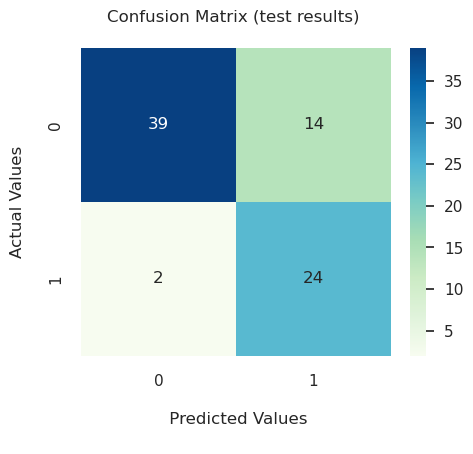

In [218]:
evaluate(lr, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[144  67]
 [ 18  86]]
ACCURACY SCORE:
0.7302
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.888889    0.562092  0.730159    0.725490      0.780994
recall       0.682464    0.826923  0.730159    0.754694      0.730159
f1-score     0.772118    0.669261  0.730159    0.720689      0.738159
support    211.000000  104.000000  0.730159  315.000000    315.000000
------------------------------------------------------------------------
TESTING RESULTS: 
CONFUSION MATRIX:
[[39 14]
 [ 3 23]]
ACCURACY SCORE:
0.7848
CLASSIFICATION REPORT:
                   0          1  accuracy  macro avg  weighted avg
precision   0.928571   0.621622   0.78481   0.775097      0.827550
recall      0.735849   0.884615   0.78481   0.810232      0.784810
f1-score    0.821053   0.730159   0.78481   0.775606      0.791138
support    53.000000  26.000000   0.78481  79.000000     79.000000


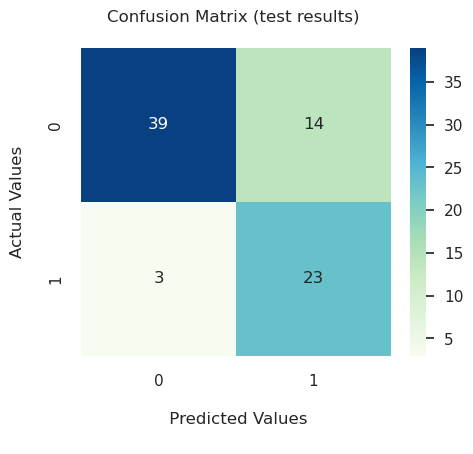

In [226]:
evaluate(lr, X_train_scaled_PCA, X_test_scaled_PCA, y_train, y_test)

* Z uwagi na nierówny udział elementów należących do różnych klas - '0' i '1' przy tworzeniu modeli została zastosowana opcja class_weight='balanced'.
* W tym przypadku zastosowanie metryki 'accuracy' do porównania obu modeli nie jest najlepszym wyborem.
* W przypadku analizowanych danych koszt fałszywego negatywnego wyniku jest WIĘKSZY niż koszt fałszywego pozytywnego wyniku, musimy zminimalizować liczbę fałszywych negatywów - ważną metryką do maksymalizacji jest 'recall'.
* W przypadku modelu po redukcji ilości zmiennych (PCA), pomimo nieznacznie mniejszej dokładności, wartość 'recall' dla ketegorii 1 (cukrzycy) jest wyższa o blisko 4%, w związku z tym, przy zadanym problemie, model ten uznaje za lepszy. 